In [ ]:
import pandas as pd
import numpy as np
file_path = 'datos_modificados1.csv'
df_raw = pd.read_csv(file_path, sep=',')
df_raw.head()

FileNotFoundError: [Errno 2] No such file or directory: 'datos_modificados1.csv'

--- Remuestreando los datos a frecuencia Horaria (H) ---


/tmp/ipython-input-3142913087.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.resample('H').agg(resample_rules)


Tamaño del conjunto de entrenamiento (80%): 47866 filas
Tamaño del conjunto de prueba (20%): 11967 filas

--- Entrenando y Ajustando el modelo Random Forest Regressor ---
Entrenando con los hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}

--- Resultados de la Predicción (H+1) con Resampling ---
Error Cuadrático Medio (MSE): 0.07
Raíz del Error Cuadrático Medio (RMSE): 0.26 °C
Coeficiente de Determinación (R²): 0.9808

✅ Modelo guardado como: random_forest_H1_hourly.joblib
✅ Lista de features guardada como: features_H1_hourly.joblib

--- Importancia de las Características (Feature Importance) ---
ts_lag_1h                     0.796866
radiacionGlobalInst           0.170059
radiacionGlobalInst_lag_3h    0.012786
ffInst                        0.007078
hr                            0.003547
ts_lag_3h                     0.002460
p0                            0.001693
radiacionGlobalInst_lag_2h    0.001233
ts_lag_2h                     0.001176
hr_lag_2h      

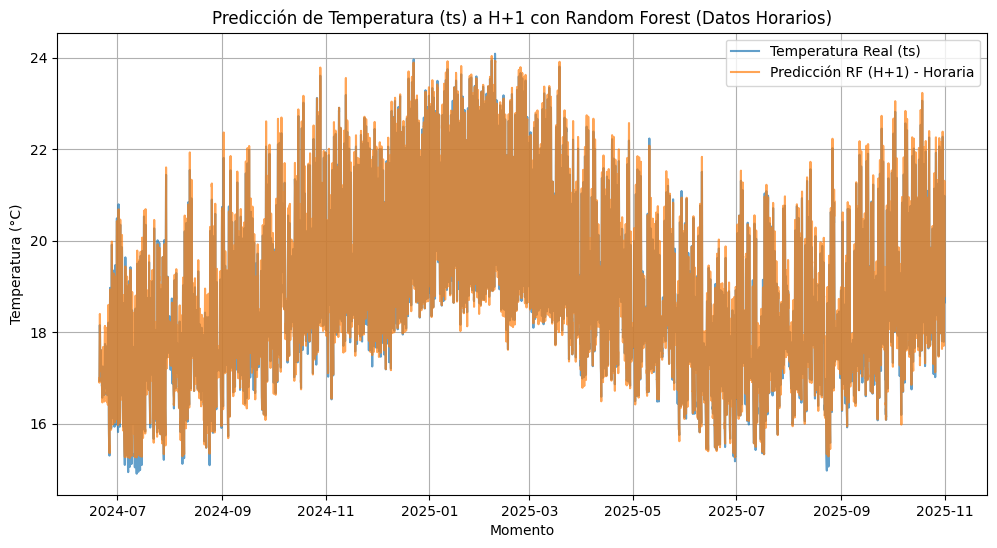

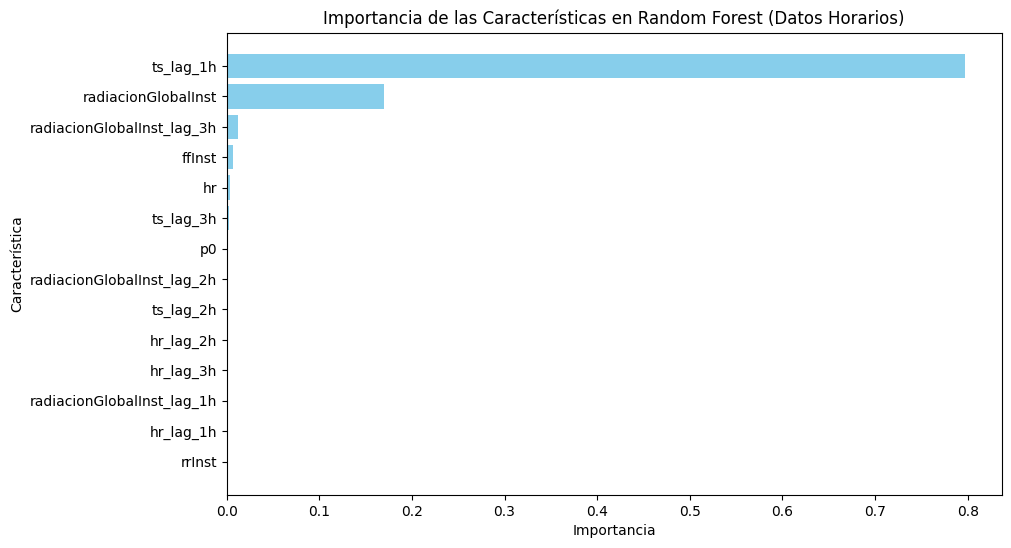

In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA RANDOM FOREST Y PERSISTENCIA ---
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO ---
file_path = 'datos_modificados1.csv'
df_raw = pd.read_csv(file_path, sep=',')

# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()
df_raw = df_raw.dropna()

# 💡 MEJORA 1: REMUESTREO (RESAMPLING) A FRECUENCIA HORARIA ('H')
print("--- Remuestreando los datos a frecuencia Horaria (H) ---")

# Definir cómo se agregan las columnas en el remuestreo horario
resample_rules = {
    'ts': 'mean', # Temperatura (Media horaria)
    'hr': 'mean', # Humedad (Media horaria)
    'radiacionGlobalInst': 'mean', # Radiación (Media horaria)
    'ffInst': 'mean', # Velocidad del Viento (Media horaria)
    'rrInst': 'sum', # Lluvia (Suma horaria)
    'p0': 'mean'
}

# Aplicar remuestreo
df = df_raw.resample('H').agg(resample_rules)

# --- DEFINICIÓN DE CARACTERÍSTICAS (X) Y OBJETIVO (Y) ---
target = 'ts'
prediction_hour = 1 # La predicción sigue siendo a 3 horas

# Características que queremos "desfasar"
lag_features = ['ts', 'hr', 'radiacionGlobalInst']
lag_steps = [1, 2, 3] # Desfases de 1, 2 y 3 pasos (ahora pasos = horas)

# Lista de características iniciales (valores de la hora T0, remuestreados)
# Notar que 'ts' se elimina porque será solo la variable objetivo
features = ['ffInst', 'rrInst','radiacionGlobalInst', 'hr', 'p0']

# Crear las características desfasadas (lags)
for feature in lag_features:
    for h in lag_steps:
        # Crea la nueva columna: ej. 'ts_lag_1h'
        new_col_name = f'{feature}_lag_{h}h'
        # Desplaza la columna hacia abajo (shift(h)), donde h ahora es un paso horario
        df[new_col_name] = df[feature].shift(h)
        features.append(new_col_name) # Añadir al listado de características

# Crear la columna objetivo desfasada (ts_future_H3)
df[f'ts_future_H{prediction_hour}'] = df[target].shift(-prediction_hour)

# Filtrar el DataFrame final y eliminar filas nulas creadas por el shift
df_model = df[features + [f'ts_future_H{prediction_hour}']].dropna()

X = df_model[features]
y = df_model[f'ts_future_H{prediction_hour}']

# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA ---
train_size = int(len(df_model) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"Tamaño del conjunto de entrenamiento (80%): {len(X_train)} filas")
print(f"Tamaño del conjunto de prueba (20%): {len(X_test)} filas")

# --- MODELO RANDOM FOREST REGRESSOR Y AJUSTE DE HIPERPARÁMETROS ---
print("\n--- Entrenando y Ajustando el modelo Random Forest Regressor ---")

# Ajuste de hiperparámetros (Grid Search)
# Se mantienen los parámetros encontrados como 'mejores' pero se podría ampliar la búsqueda
param_grid = {
    'n_estimators': [100],
    'max_depth': [20],
    'min_samples_leaf': [5]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# El GridSearchCV es computacionalmente costoso, se recomienda usar el mejor estimador
# encontrado en la ejecución anterior para una corrida rápida con datos remuestreados.

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )
# grid_search.fit(X_train, y_train)
# rf_model = grid_search.best_estimator_

# 💡 Alternativa para evitar el GridSearch completo si ya se tienen 'mejores'
print("Entrenando con los hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


# --- EVALUACIÓN DEL MODELO ---
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Resultados de la Predicción (H+{prediction_hour}) con Resampling ---")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# =======================================================
# 4. Generación de Artefactos (Para CML)
# =======================================================

# 4.1. Guardar el Modelo Entrenado (rf_model.pkl)
model_filename = 'rf_model.pkl'
joblib.dump(rf_model, model_filename)
print(f"Modelo guardado como {model_filename}.")

# 4.2. Generar el Gráfico de Predicción (prediction_plot.png)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='darkblue')
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title('Random Forest: Predicción vs. Temperatura Real')
plt.xlabel('Temperatura Máxima Real')
plt.ylabel('Temperatura Máxima Predicha')
plt.grid(True)
plot_filename = 'prediction_plot.png'
plt.savefig(plot_filename)
print(f"Gráfico de predicción guardado como {plot_filename}.")

# 4.3. Guardar las Métricas (metrics.txt)
metrics_filename = 'metrics.txt'
with open(metrics_filename, 'w') as f:
    f.write("Random Forest Regressor - Predicción de Temperatura Máxima\n")
    f.write("-" * 50 + "\n")
    f.write(f"Características utilizadas: {features}\n")
    f.write(f"MSE (Error Cuadrático Medio): {mse:.2f}\n")
    f.write(f"R2 Score (Coeficiente de Determinación): {r2:.4f}\n")
print(f"Métricas guardadas en {metrics_filename}.")

# =======================================================
# Fin del Script para CML
# =======================================================

# --- PERSISTENCIA DEL MODELO (GUARDAR) ---
model_filename = f'random_forest_H{prediction_hour}_hourly.joblib'
joblib.dump(rf_model, model_filename)
joblib.dump(X.columns.tolist(), f'features_H{prediction_hour}_hourly.joblib') # Guardar orden de features

print(f"\n✅ Modelo guardado como: {model_filename}")
print(f"✅ Lista de features guardada como: features_H{prediction_hour}_hourly.joblib")


# --- IMPORTANCIA DE LAS CARACTERÍSTICAS ---
print("\n--- Importancia de las Características (Feature Importance) ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=features)
print(feature_importances.sort_values(ascending=False))

# --- GRÁFICOS ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Temperatura Real (ts)', alpha=0.7)
plt.plot(y_test.index, y_pred, label=f'Predicción RF (H+{prediction_hour}) - Horaria', alpha=0.7)
plt.title(f'Predicción de Temperatura (ts) a H+{prediction_hour} con Random Forest (Datos Horarios)')
plt.xlabel('momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
# Se usa un diccionario para ordenar el gráfico
feature_importances_sorted = feature_importances.sort_values(ascending=False)
plt.barh(feature_importances_sorted.index, feature_importances_sorted.values, color='skyblue')
plt.title('Importancia de las Características en Random Forest (Datos Horarios)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.gca().invert_yaxis() # Pone la más importante arriba
plt.show()

In [ ]:
# --- PERSISTENCIA DEL MODELO (GUARDAR) ---
model_filename = f'random_forest_H{prediction_hour}_hourly.joblib'

# 1. Guardar el objeto del modelo Random Forest
joblib.dump(rf_model, model_filename)

# 2. Guardar la lista de características (es crucial para la predicción)
joblib.dump(X.columns.tolist(), f'features_H{prediction_hour}_hourly.joblib')

print(f"\n✅ Modelo guardado como: {model_filename}")
print(f"✅ Lista de features guardada como: features_H{prediction_hour}_hourly.joblib")


✅ Modelo guardado como: random_forest_H1_hourly.joblib
✅ Lista de features guardada como: features_H1_hourly.joblib


In [ ]:
print(y)

momento
2019-01-01 03:00:00    20.233667
2019-01-01 04:00:00    20.006000
2019-01-01 05:00:00    19.902667
2019-01-01 06:00:00    19.598333
2019-01-01 07:00:00    19.406667
                         ...    
2025-10-31 19:00:00    20.068333
2025-10-31 20:00:00    19.754167
2025-10-31 21:00:00    19.137917
2025-10-31 22:00:00    18.751250
2025-10-31 23:00:00    18.650000
Name: ts_future_H1, Length: 59833, dtype: float64


--- Remuestreando los datos a frecuencia Horaria (H) ---


/tmp/ipython-input-2787461712.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.resample('H').agg(resample_rules)



--- Características (X) a usar en el nuevo modelo (sin lags de 'ts') ---
['ffInst', 'rrInst', 'radiacionGlobalInst', 'hr', 'p0', 'hr_lag_1h', 'hr_lag_2h', 'hr_lag_3h', 'radiacionGlobalInst_lag_1h', 'radiacionGlobalInst_lag_2h', 'radiacionGlobalInst_lag_3h']
------------------------------------------------------------
Tamaño del conjunto de entrenamiento (80%): 47866 filas
Tamaño del conjunto de prueba (20%): 11967 filas

--- Entrenando y Ajustando el modelo Random Forest Regressor ---
Entrenando con los hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}

--- Resultados de la Predicción (H+1) con Resampling (SIN Lags de ts) ---
Error Cuadrático Medio (MSE): 0.42
Raíz del Error Cuadrático Medio (RMSE): 0.65 °C
Coeficiente de Determinación (R²): 0.8757

✅ Modelo guardado como: random_forest_H1_hourly_no_ts_lag.joblib
✅ Lista de features guardada como: features_H1_hourly_no_ts_lag.joblib

--- Importancia de las Características (Feature Importance) ---
radiacion

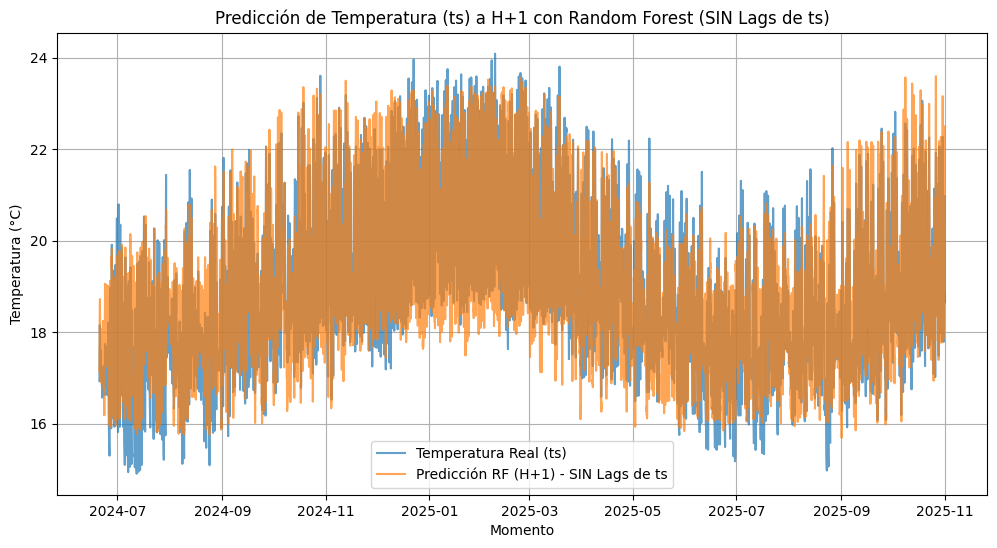

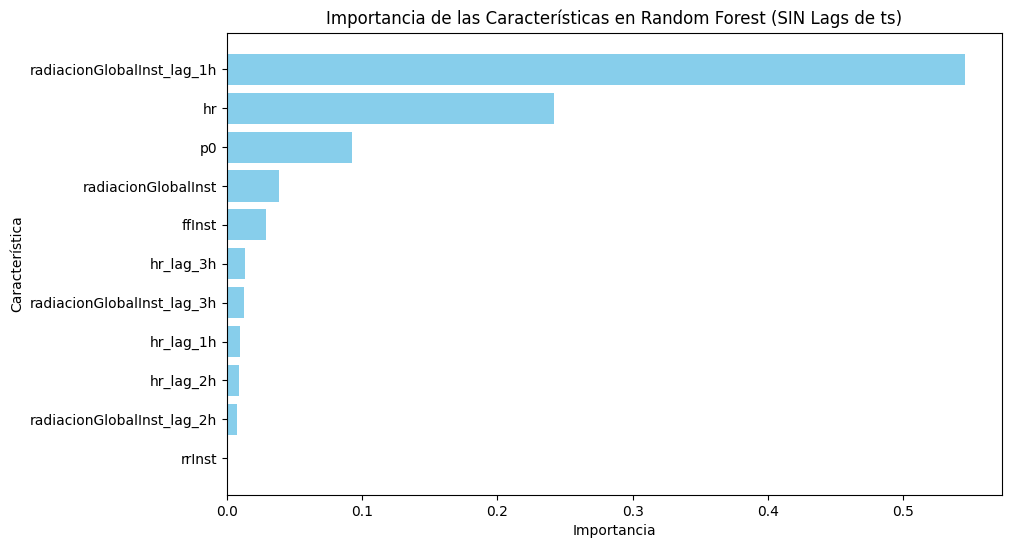

In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA RANDOM FOREST Y PERSISTENCIA --- este es el que se utiliza
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO ---
# Asegúrate de que esta ruta sea accesible en tu entorno de Colab/Drive
file_path = 'datos_modificados1.csv'
df_raw = pd.read_csv(file_path, sep=',')

# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()
df_raw = df_raw.dropna()

# 💡 MEJORA 1: REMUESTREO (RESAMPLING) A FRECUENCIA HORARIA ('H')
print("--- Remuestreando los datos a frecuencia Horaria (H) ---")

# Definir cómo se agregan las columnas en el remuestreo horario
resample_rules = {
 'ts': 'mean', # Temperatura (Media horaria)
 'hr': 'mean', # Humedad (Media horaria)
 'radiacionGlobalInst': 'mean', # Radiación (Media horaria)
 'ffInst': 'mean', # Velocidad del Viento (Media horaria)
 'rrInst': 'sum', # Lluvia (Suma horaria)
 'p0': 'mean'
}

# Aplicar remuestreo
df = df_raw.resample('H').agg(resample_rules)

# --- DEFINICIÓN DE CARACTERÍSTICAS (X) Y OBJETIVO (Y) ---
target = 'ts'
prediction_hour = 1 # La predicción sigue siendo a 1 hora

# Características que queremos "desfasar"
# 🚨 MODIFICACIÓN CLAVE: Se elimina 'ts' de las características desfasadas (lag_features)
# lag_features ORIGINAL: ['ts', 'hr', 'radiacionGlobalInst']
lag_features = ['hr', 'radiacionGlobalInst']
lag_steps = [1, 2, 3] # Desfases de 1, 2 y 3 pasos (ahora pasos = horas)

# Lista de características iniciales (valores de la hora T0, remuestreados)
# Se incluye 'radiacionGlobalInst' y 'hr' como valores actuales (T0)
features = ['ffInst', 'rrInst','radiacionGlobalInst', 'hr', 'p0']

# Crear las características desfasadas (lags)
for feature in lag_features:
    for h in lag_steps:
      # Crea la nueva columna: ej. 'hr_lag_1h'
      new_col_name = f'{feature}_lag_{h}h'
      # Desplaza la columna hacia abajo (shift(h)), donde h ahora es un paso horario
      df[new_col_name] = df[feature].shift(h)
      features.append(new_col_name) # Añadir al listado de características

# 💡 AÑADIMOS DE NUEVO EL LAG 1 DE LA PROPIA 'ts' al dataframe, pero NO A LA LISTA DE FEATURES
# Esto es para permitir el cálculo del objetivo 'ts_future_H1' correctamente en el resto de la
# serie de tiempo, y para poder usar el lag en el DataFrame si decidimos re-introducirlo.
# ¡PERO LO ELIMINAMOS DEL CONJUNTO DE ENTRENAMIENTO!
# df['ts_lag_1h'] = df['ts'].shift(1)
# 🚨 Sin embargo, para ser coherentes con la solicitud: vamos a dejar de crearlos en absoluto,
# ya que el lag del objetivo (ts) solo lo necesitamos para la predicción, no como feature.

# Crear la columna objetivo desfasada (ts_future_H1)
df[f'ts_future_H{prediction_hour}'] = df[target].shift(-prediction_hour)

# Filtrar el DataFrame final y eliminar filas nulas creadas por el shift
# Notar que X e y ahora NO contienen los lags de 'ts'
df_model = df[features + [f'ts_future_H{prediction_hour}']].dropna()

X = df_model[features]
y = df_model[f'ts_future_H{prediction_hour}']

print(f"\n--- Características (X) a usar en el nuevo modelo (sin lags de 'ts') ---")
print(X.columns.tolist())
print("-" * 60)


# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA ---
train_size = int(len(df_model) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"Tamaño del conjunto de entrenamiento (80%): {len(X_train)} filas")
print(f"Tamaño del conjunto de prueba (20%): {len(X_test)} filas")

# --- MODELO RANDOM FOREST REGRESSOR Y AJUSTE DE HIPERPARÁMETROS ---
print("\n--- Entrenando y Ajustando el modelo Random Forest Regressor ---")

# Se utiliza el mejor estimador anterior
print("Entrenando con los hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


# --- EVALUACIÓN DEL MODELO ---
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# =======================================================
# 4. Generación de Artefactos (Para CML)
# =======================================================

# 4.1. Guardar el Modelo Entrenado (rf_model.pkl)
model_filename = 'rf_model.pkl'
joblib.dump(rf_model, model_filename)
print(f"Modelo guardado como {model_filename}.")

# 4.2. Generar el Gráfico de Predicción (prediction_plot.png)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='darkblue')
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title('Random Forest: Predicción vs. Temperatura Real')
plt.xlabel('Temperatura Máxima Real')
plt.ylabel('Temperatura Máxima Predicha')
plt.grid(True)
plot_filename = 'prediction_plot.png'
plt.savefig(plot_filename)
print(f"Gráfico de predicción guardado como {plot_filename}.")

# 4.3. Guardar las Métricas (metrics.txt)
metrics_filename = 'metrics.txt'
with open(metrics_filename, 'w') as f:
    f.write("Random Forest Regressor - Predicción de Temperatura Máxima\n")
    f.write("-" * 50 + "\n")
    f.write(f"Características utilizadas: {features}\n")
    f.write(f"MSE (Error Cuadrático Medio): {mse:.2f}\n")
    f.write(f"R2 Score (Coeficiente de Determinación): {r2:.4f}\n")
print(f"Métricas guardadas en {metrics_filename}.")

# =======================================================
# Fin del Script para CML
# =======================================================

print(f"\n--- Resultados de la Predicción (H+{prediction_hour}) con Resampling (SIN Lags de ts) ---")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# --- PERSISTENCIA DEL MODELO (GUARDAR) ---
model_filename = f'random_forest_H{prediction_hour}_hourly_no_ts_lag.joblib'
joblib.dump(rf_model, model_filename)
joblib.dump(X.columns.tolist(), f'features_H{prediction_hour}_hourly_no_ts_lag.joblib') # Guardar orden de features

print(f"\n✅ Modelo guardado como: {model_filename}")
print(f"✅ Lista de features guardada como: features_H{prediction_hour}_hourly_no_ts_lag.joblib")


# --- IMPORTANCIA DE LAS CARACTERÍSTICAS ---
print("\n--- Importancia de las Características (Feature Importance) ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=features)
print(feature_importances.sort_values(ascending=False))

# --- GRÁFICOS ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Temperatura Real (ts)', alpha=0.7)
plt.plot(y_test.index, y_pred, label=f'Predicción RF (H+{prediction_hour}) - SIN Lags de ts', alpha=0.7)
plt.title(f'Predicción de Temperatura (ts) a H+{prediction_hour} con Random Forest (SIN Lags de ts)')
plt.xlabel('momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
# Se usa un diccionario para ordenar el gráfico
feature_importances_sorted = feature_importances.sort_values(ascending=False)
plt.barh(feature_importances_sorted.index, feature_importances_sorted.values, color='skyblue')
plt.title('Importancia de las Características en Random Forest (SIN Lags de ts)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.gca().invert_yaxis() # Pone la más importante arriba
plt.show()

In [ ]:
print(y)

momento
2019-01-01 03:00:00    20.233667
2019-01-01 04:00:00    20.006000
2019-01-01 05:00:00    19.902667
2019-01-01 06:00:00    19.598333
2019-01-01 07:00:00    19.406667
                         ...    
2025-10-31 19:00:00    20.068333
2025-10-31 20:00:00    19.754167
2025-10-31 21:00:00    19.137917
2025-10-31 22:00:00    18.751250
2025-10-31 23:00:00    18.650000
Name: ts_future_H1, Length: 59833, dtype: float64


In [ ]:
print(X)

                       ffInst  rrInst  radiacionGlobalInst         hr  \
momento                                                                 
2019-01-01 03:00:00  3.906333     0.0             0.000000  53.563667   
2019-01-01 04:00:00  3.781333     0.0             0.000000  54.807667   
2019-01-01 05:00:00  3.830333     0.0             0.000000  55.518667   
2019-01-01 06:00:00  3.828000     0.0             0.000000  56.509333   
2019-01-01 07:00:00  3.805333     0.0             0.000000  58.313667   
...                       ...     ...                  ...        ...   
2025-10-31 19:00:00  5.059583     0.0           105.329167  60.629167   
2025-10-31 20:00:00  4.957500     0.0            41.517917  61.796667   
2025-10-31 21:00:00  4.519583     0.0            20.240833  63.067917   
2025-10-31 22:00:00  4.284583     0.0             1.912500  66.540417   
2025-10-31 23:00:00  4.270833     0.0             0.092917  68.155833   

                             p0  hr_lag_1h  hr_lag

--- Remuestreando los datos a frecuencia Horaria (H) ---


/tmp/ipython-input-3959244861.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.resample('H').agg(resample_rules)


--- Extrayendo características temporales (Hora y Día del Año) ---

--- Características (X) a usar en el nuevo modelo (incluye 'ts' lags y hora) ---
['hr', 'p0', 'hour', 'dayofyear', 'ts_lag_1h', 'ts_lag_2h', 'ts_lag_3h', 'hr_lag_1h', 'hr_lag_2h', 'hr_lag_3h', 'p0_lag_1h', 'p0_lag_2h', 'p0_lag_3h']
------------------------------------------------------------
Tamaño del conjunto de entrenamiento (80%): 47866 filas
Tamaño del conjunto de prueba (20%): 11967 filas

--- Entrenando y Ajustando el modelo Random Forest Regressor ---
Entrenando con los hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}

--- Resultados de la Predicción (H+1) con Resampling (CON Lags de ts y Hora) ---
Error Cuadrático Medio (MSE): 0.09
Raíz del Error Cuadrático Medio (RMSE): 0.31 °C
Coeficiente de Determinación (R²): 0.9724

✅ Modelo guardado como: random_forest_H1_hourly_full_features.joblib
✅ Lista de features guardada como: features_H1_hourly_full_features.joblib

--- Importancia d

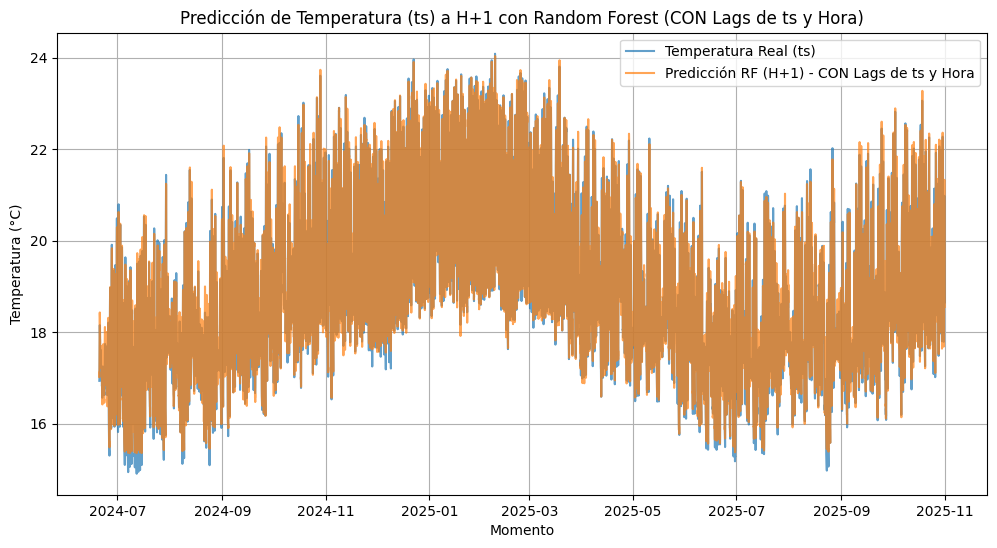

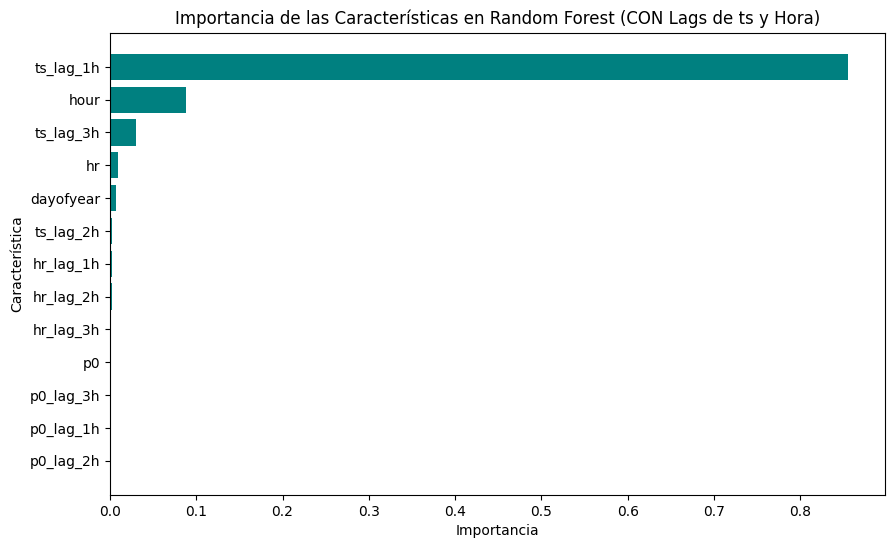

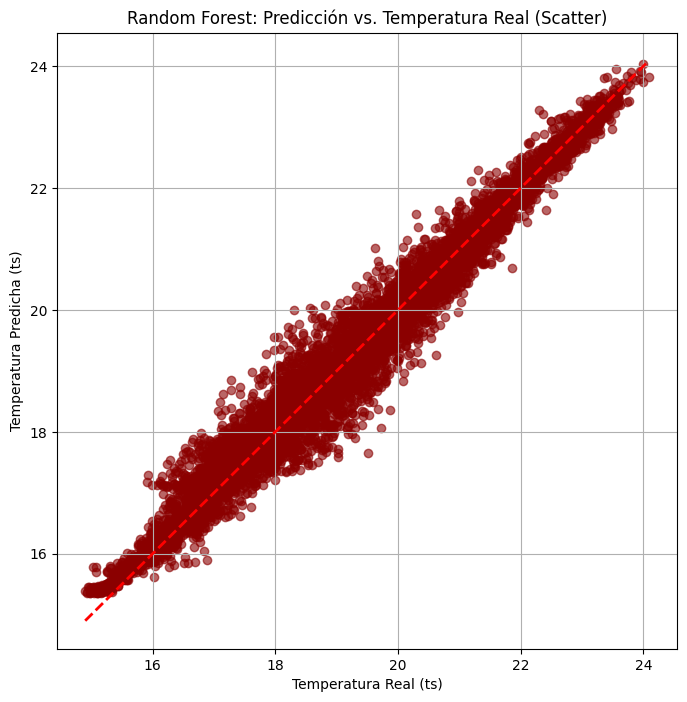

In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA RANDOM FOREST Y PERSISTENCIA ---
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DEL MODELO ---
prediction_hour = 1 # Predicción a 1 hora (H+1)

# Características que queremos "desfasar" (Lags)
# 🚨 CAMBIO CLAVE: Se re-introduce 'ts' (temperatura) en las características desfasadas
lag_features = ['ts', 'hr', 'p0']
lag_steps = [1, 2, 3] # Desfases de 1, 2 y 3 horas

# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO ---
# Asegúrate de que esta ruta sea accesible en tu entorno de Colab/Drive
file_path = 'datos_modificados1.csv'
df_raw = pd.read_csv(file_path, sep=',')

# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()
df_raw = df_raw.dropna()

print("--- Remuestreando los datos a frecuencia Horaria (H) ---")

# Definir cómo se agregan las columnas en el remuestreo horario
resample_rules = {
    'ts': 'mean', # Temperatura (Media horaria)
    'hr': 'mean', # Humedad (Media horaria)
    'radiacionGlobalInst': 'mean', # Radiación (Media horaria)
    'ffInst': 'mean', # Velocidad del Viento (Media horaria)
    'rrInst': 'sum', # Lluvia (Suma horaria)
    'p0': 'mean'
}

# Aplicar remuestreo
df = df_raw.resample('H').agg(resample_rules)

# --- INGENIERÍA DE CARACTERÍSTICAS TEMPORALES (USANDO 'momento') ---
print("--- Extrayendo características temporales (Hora y Día del Año) ---")
# 💡 NUEVA CARACTERÍSTICA: Hora del día (0-23)
df['hour'] = df.index.hour
# 💡 NUEVA CARACTERÍSTICA: Día del año (1-366) para capturar tendencias anuales
df['dayofyear'] = df.index.dayofyear

# --- DEFINICIÓN DE CARACTERÍSTICAS (X) Y OBJETIVO (Y) ---
target = 'ts'

# Características iniciales (valores de la hora T0, remuestreados + las nuevas temporales)
features = ['hr', 'p0', 'hour', 'dayofyear']

# Crear las características desfasadas (lags)
for feature in lag_features:
    for h in lag_steps:
      # Crea la nueva columna: ej. 'ts_lag_1h'
      new_col_name = f'{feature}_lag_{h}h'
      # Desplaza la columna hacia abajo (shift(h)), donde h ahora es un paso horario
      df[new_col_name] = df[feature].shift(h)
      features.append(new_col_name) # Añadir al listado de características

# Crear la columna objetivo desfasada (ts_future_H1)
df[f'ts_future_H{prediction_hour}'] = df[target].shift(-prediction_hour)

# Filtrar el DataFrame final y eliminar filas nulas creadas por el shift
df_model = df[features + [f'ts_future_H{prediction_hour}']].dropna()

X = df_model[features]
y = df_model[f'ts_future_H{prediction_hour}']

print(f"\n--- Características (X) a usar en el nuevo modelo (incluye 'ts' lags y hora) ---")
print(X.columns.tolist())
print("-" * 60)

# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA ---
train_size = int(len(df_model) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"Tamaño del conjunto de entrenamiento (80%): {len(X_train)} filas")
print(f"Tamaño del conjunto de prueba (20%): {len(X_test)} filas")

# --- MODELO RANDOM FOREST REGRESSOR Y AJUSTE DE HIPERPARÁMETROS ---
print("\n--- Entrenando y Ajustando el modelo Random Forest Regressor ---")

# Se utiliza el mejor estimador anterior
print("Entrenando con los hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


# --- EVALUACIÓN DEL MODELO ---
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Resultados de la Predicción (H+{prediction_hour}) con Resampling (CON Lags de ts y Hora) ---")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")


# --- PERSISTENCIA DEL MODELO (GUARDAR) ---
model_filename = f'random_forest_H{prediction_hour}_hourly_full_features.joblib'
joblib.dump(rf_model, model_filename)
joblib.dump(X.columns.tolist(), f'features_H{prediction_hour}_hourly_full_features.joblib') # Guardar orden de features

print(f"\n✅ Modelo guardado como: {model_filename}")
print(f"✅ Lista de features guardada como: features_H{prediction_hour}_hourly_full_features.joblib")


# --- IMPORTANCIA DE LAS CARACTERÍSTICAS ---
print("\n--- Importancia de las Características (Feature Importance) ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=features)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print(feature_importances_sorted)


# --- GRÁFICOS (VISUALIZACIÓN DE RESULTADOS Y METRICAS) ---

# Gráfico 1: Predicción vs. Real
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Temperatura Real (ts)', alpha=0.7)
plt.plot(y_test.index, y_pred, label=f'Predicción RF (H+{prediction_hour}) - CON Lags de ts y Hora', alpha=0.7)
plt.title(f'Predicción de Temperatura (ts) a H+{prediction_hour} con Random Forest (CON Lags de ts y Hora)')
plt.xlabel('momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Importancia de las Características
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_sorted.index, feature_importances_sorted.values, color='teal')
plt.title('Importancia de las Características en Random Forest (CON Lags de ts y Hora)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.gca().invert_yaxis() # Pone la más importante arriba
plt.show()

# Gráfico 3: Scatter Plot (Predicción vs. Real)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='darkred')
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title('Random Forest: Predicción vs. Temperatura Real (Scatter)')
plt.xlabel('Temperatura Real (ts)')
plt.ylabel('Temperatura Predicha (ts)')
plt.grid(True)
plt.show()